In [12]:
# Import libraries
import os
import sys
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from collections import Counter, defaultdict
from rdflib import Graph, Namespace, URIRef
from rdflib.namespace import RDF, RDFS
import random
from IPython.display import display, HTML
import re

# Add the project root to Python's path
project_root = os.path.abspath(os.path.join(os.getcwd(), ".."))
sys.path.append(project_root)

# Define paths
turtle_dir = os.path.join(project_root, "polianna-processed", "turtle")
raw_text_dir = os.path.join(project_root, "polianna-dataset", "data", "03a_processed_to_jsonl")

# Define namespaces
POLIANN = Namespace("https://polianna-kg.org/Ontology#")
ELI     = Namespace("http://data.europa.eu/eli/ontology#")
SKOS    = Namespace("http://www.w3.org/2004/02/skos/core#")

In [14]:
def load_all_turtle_files(directory):
    """Load all .ttl files from a directory and return a dictionary of graphs."""
    graphs = {}
    file_count = 0
    
    for filename in os.listdir(directory):
        if filename.endswith(".ttl"):
            file_path = os.path.join(directory, filename)
            article_id = filename[:-4]  # Remove .ttl extension
            
            g = Graph()
            g.parse(file_path, format="turtle")
            graphs[article_id] = g
            file_count += 1
            
            if file_count % 100 == 0:
                print(f"Loaded {file_count} files...")
    
    print(f"Loaded {file_count} Turtle files in total.")
    return graphs

In [15]:
def analyze_time_entities(graphs):
    """Analyze time entities with structured date information."""
    
    compliance_dates = []
    in_effect_dates = []
    unparseable_compliance = []
    unparseable_effect = []
    
    for article_id, g in graphs.items():
        # Query compliance dates
        compliance_query = """
        PREFIX poliann: <https://polianna-kg.org/Ontology#>
        SELECT ?text ?date WHERE {
            ?time a poliann:Time_Compliance ;
                  poliann:annotatedText ?text .
            OPTIONAL { ?time poliann:Compliance_date ?date }
        }
        """
        
        for row in g.query(compliance_query):
            text, date = row
            if date:
                compliance_dates.append((article_id, str(text), str(date)))
            else:
                unparseable_compliance.append((article_id, str(text)))
        
        # Query in-effect dates
        effect_query = """
        PREFIX poliann: <https://polianna-kg.org/Ontology#>
        SELECT ?text ?date WHERE {
            ?time a poliann:Time_InEffect ;
                  poliann:annotatedText ?text .
            OPTIONAL { ?time poliann:In_effect_date ?date }
        }
        """
        
        for row in g.query(effect_query):
            text, date = row
            if date:
                in_effect_dates.append((article_id, str(text), str(date)))
            else:
                unparseable_effect.append((article_id, str(text)))
    
    # Create DataFrames
    compliance_df = pd.DataFrame(compliance_dates, columns=['article_id', 'text', 'date'])
    effect_df = pd.DataFrame(in_effect_dates, columns=['article_id', 'text', 'date'])
    
    # Calculate statistics
    parseable_compliance_pct = len(compliance_dates) / (len(compliance_dates) + len(unparseable_compliance)) * 100
    parseable_effect_pct = len(in_effect_dates) / (len(in_effect_dates) + len(unparseable_effect)) * 100
    
    print(f"Compliance dates: {len(compliance_dates)} parseable ({parseable_compliance_pct:.1f}%), {len(unparseable_compliance)} unparseable")
    print(f"In-effect dates: {len(in_effect_dates)} parseable ({parseable_effect_pct:.1f}%), {len(unparseable_effect)} unparseable")
    
    return {
        'compliance_dates': compliance_df,
        'effect_dates': effect_df,
        'unparseable_compliance': pd.DataFrame(unparseable_compliance, columns=['article_id', 'text']),
        'unparseable_effect': pd.DataFrame(unparseable_effect, columns=['article_id', 'text'])
    }

def analyze_date_patterns(date_analysis):
    """Analyze patterns in date expressions."""
    
    # Create pattern columns
    date_analysis['unparseable_compliance']['pattern'] = date_analysis['unparseable_compliance']['text'].apply(categorize_date_pattern)
    date_analysis['unparseable_effect']['pattern'] = date_analysis['unparseable_effect']['text'].apply(categorize_date_pattern)
    
    # Count patterns
    compliance_patterns = date_analysis['unparseable_compliance']['pattern'].value_counts()
    effect_patterns = date_analysis['unparseable_effect']['pattern'].value_counts()
    
    print("Common unparseable compliance date patterns:")
    display(compliance_patterns.head(10))
    
    print("\nCommon unparseable in-effect date patterns:")
    display(effect_patterns.head(10))
    
    # Plot pattern distributions
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 10))
    
    compliance_patterns.head(8).plot(kind='barh', ax=ax1)
    ax1.set_title('Common Compliance Date Patterns')
    ax1.set_xlabel('Count')
    
    effect_patterns.head(8).plot(kind='barh', ax=ax2)
    ax2.set_title('Common In-Effect Date Patterns')
    ax2.set_xlabel('Count')
    
    plt.tight_layout()
    plt.show()
    
    return {
        'compliance_patterns': compliance_patterns,
        'effect_patterns': effect_patterns
    }

def categorize_date_pattern(text):
    """Categorize date expressions into patterns."""
    text = text.lower()
    
    if "following" in text and "publication" in text:
        return "after_publication"
    elif "within" in text and ("month" in text or "year" in text):
        return "within_timeframe"
    elif "every" in text and ("year" in text or "month" in text):
        return "recurring"
    elif "from" in text and "to" in text:
        return "date_range"
    elif "not later than" in text or "no later than" in text:
        return "deadline"
    elif "by" in text and re.search(r'\d{4}', text):
        return "by_year"
    elif "after" in text:
        return "after_event"
    elif "before" in text:
        return "before_event"
    else:
        return "other"

Loaded 100 files...
Loaded 200 files...
Loaded 300 files...
Loaded 400 files...
Loaded 412 Turtle files in total.
Loaded 412 graph files
Compliance dates: 237 parseable (76.5%), 73 unparseable
In-effect dates: 66 parseable (62.3%), 40 unparseable


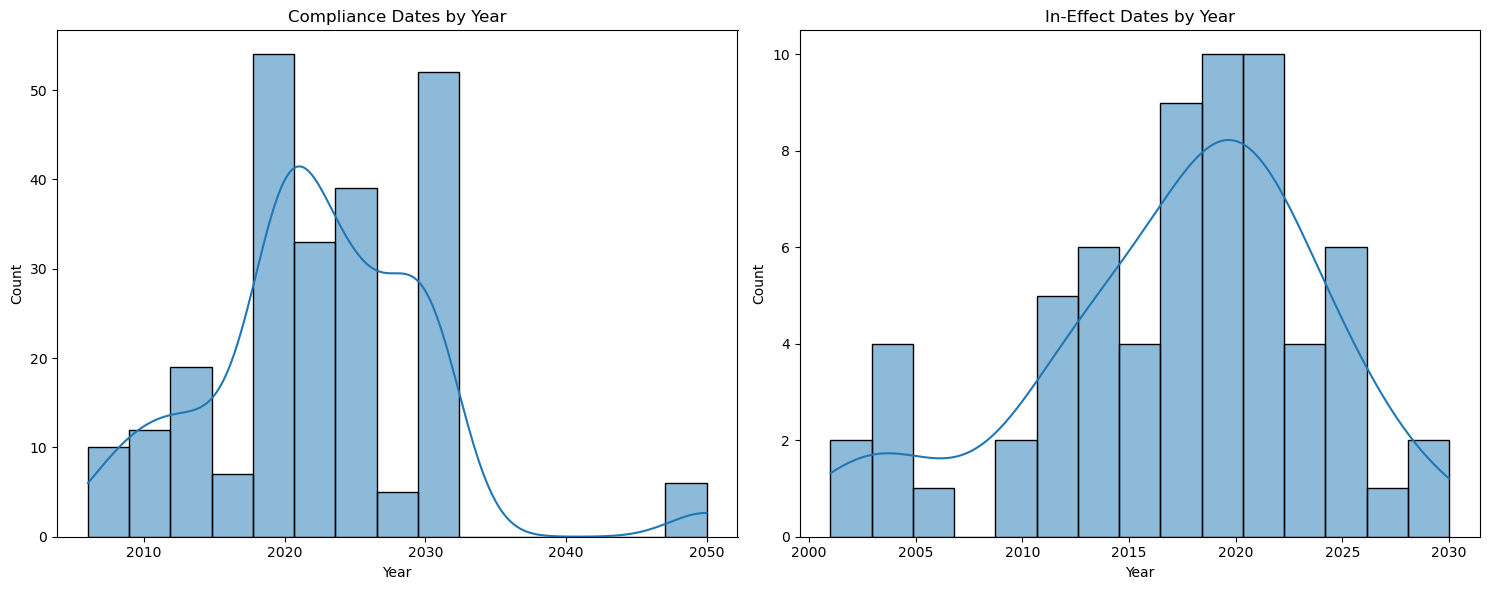

Common unparseable compliance date patterns:


pattern
other               38
within_timeframe    14
recurring            8
deadline             4
after_event          4
before_event         4
by_year              1
Name: count, dtype: int64


Common unparseable in-effect date patterns:


pattern
after_publication    26
other                13
within_timeframe      1
Name: count, dtype: int64

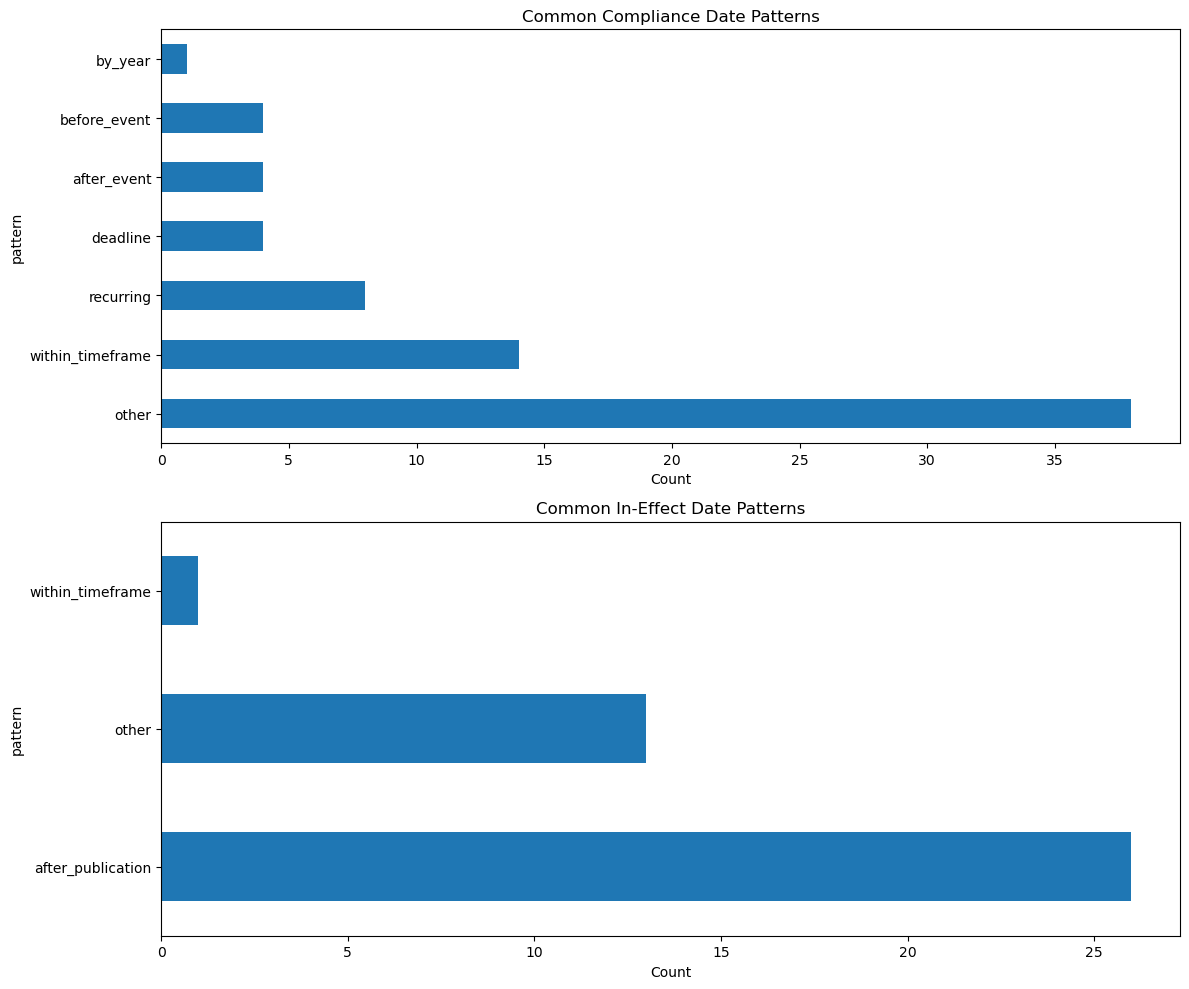


Sample of parseable compliance dates:


,article_id,text,date
0,EU_32012L0027_Title_0_Chapter_2_Section_0_Arti...,31 december 2016,2016-12-31
1,EU_32009L0028_Title_0_Chapter_0_Section_0_Arti...,5 december 2010,2010-12-05
2,EU_32018R1999_Title_0_Chapter_6_Section_3_Arti...,1 january 2021,2021-01-01
3,EU_32012L0027_Title_0_Chapter_4_Section_0_Arti...,31 december 2014,2014-12-31
4,EU_32019L0944_Title_0_Chapter_2_Section_0_Arti...,2030,2030-01-01
5,EU_32009L0028_Title_0_Chapter_0_Section_0_Arti...,31 december 2012,2012-12-31
6,EU_32009L0028_Title_0_Chapter_0_Section_0_Arti...,31 december 2012,2012-12-31
7,EU_32009L0028_Title_0_Chapter_0_Section_0_Arti...,31 march 2010,2010-03-31
8,EU_32018R1999_Title_0_Chapter_3_Section_0_Arti...,2050,2050-01-01
9,EU_32018R1999_Title_0_Chapter_3_Section_0_Arti...,1 april 2019,2019-04-01



Sample of parseable in-effect dates:


,article_id,text,date
0,EU_32019R0631_Title_0_Chapter_0_Section_0_Arti...,from 1 january 2020,2020-01-01
1,EU_32009L0028_Title_0_Chapter_0_Section_0_Arti...,1 april 2010,2010-04-01
2,EU_32009L0028_Title_0_Chapter_0_Section_0_Arti...,1 april 2010,2010-04-01
3,EU_32009L0028_Title_0_Chapter_0_Section_0_Arti...,1 january 2012,2012-01-01
4,EU_32019R0631_Title_0_Chapter_0_Section_0_Arti...,1 january 2020,2020-01-01
5,EU_32006L0032_Title_0_Chapter_3_Section_0_Arti...,16 december 2002,2002-12-16
6,EU_32018R1999_Title_0_Chapter_7_Section_3_Arti...,1 january 2021,2021-01-01
7,EU_32018R1999_Title_0_Chapter_4_Section_2_Arti...,2023,2023-01-01
8,EU_32018R1999_Title_0_Chapter_4_Section_2_Arti...,31 december 2020,2020-12-31
9,EU_32018R1999_Title_0_Chapter_4_Section_2_Arti...,31 december 2020,2020-12-31


In [16]:
# 1. Load the graph data (assuming you've already defined load_all_turtle_files)
article_graphs = load_all_turtle_files(turtle_dir)
print(f"Loaded {len(article_graphs)} graph files")

# 2. Run the time entity analysis
time_analysis = analyze_time_entities(article_graphs)

# 3. Visualize date distributions if you have parseable dates
if len(time_analysis['compliance_dates']) > 0 or len(time_analysis['effect_dates']) > 0:
    # Create visualizations for dates
    plt.figure(figsize=(15, 6))
    
    # Plot distribution of years for compliance dates
    if len(time_analysis['compliance_dates']) > 0:
        plt.subplot(1, 2, 1)
        compliance_years = pd.to_datetime(time_analysis['compliance_dates']['date']).dt.year
        sns.histplot(compliance_years, kde=True, bins=15)
        plt.title('Compliance Dates by Year')
        plt.xlabel('Year')
    
    # Plot distribution of years for in-effect dates
    if len(time_analysis['effect_dates']) > 0:
        plt.subplot(1, 2, 2)
        effect_years = pd.to_datetime(time_analysis['effect_dates']['date']).dt.year
        sns.histplot(effect_years, kde=True, bins=15)
        plt.title('In-Effect Dates by Year')
        plt.xlabel('Year')
    
    plt.tight_layout()
    plt.show()

# 4. Analyze patterns in unparseable dates
pattern_analysis = analyze_date_patterns(time_analysis)

# 5. Display some of the actual date text examples
print("\nSample of parseable compliance dates:")
if len(time_analysis['compliance_dates']) > 0:
    display(time_analysis['compliance_dates'].head(10))
else:
    print("No parseable compliance dates found.")

print("\nSample of parseable in-effect dates:")
if len(time_analysis['effect_dates']) > 0:
    display(time_analysis['effect_dates'].head(10))
else:
    print("No parseable in-effect dates found.")